# HW8 2021300003004 张天骏

## 1(a)

In [128]:
import timeit
import numpy as np
from numba import njit
import numba
import matplotlib.pyplot as plt


In [129]:
beta = 0.95
r=0.05
kmin = -1.9
kmax = 15
n_k = 2500
kgrid = np.linspace(kmin, kmax, n_k)
wgrid = np.array([0.1,1])
P=np.array([
    [0.6,0.4],
    [0.05,0.95],
])
n_w = len(wgrid)
V0 = np.zeros((n_k, n_w))

In [130]:
def u(c):
    if c > 0:
        res = np.log(c)
    else:
        res = -np.inf
    return res
if compile:
    u = njit(u)

def budget(k_next_index, k_index, w_index,r): 
        return (1+r)*kgrid[k_index] + wgrid[w_index] - kgrid[k_next_index]
if compile:
    budget = njit(budget)

def V_current(k_next_index, k_index, w_index, V_next,r):
    c = budget(k_next_index, k_index, w_index,r)
    EV = np.sum(P[w_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c) + beta * EV
    return res
if compile:
    V_current = njit(V_current)

In [131]:
def V_max(k_index, w_index,k_start,V,r):
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current(j,k_index,w_index,V,r)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start

if compile:
    V_max = njit(V_max)

In [132]:
def V_update(V,r):
    V_new = np.zeros((n_k, n_w))
    g_new = np.zeros((n_k, n_w))
    for i_w in range(n_w): # loop over all state w
        k_start = 0
        for i_k in range(k_start,n_k): # loop over all state k
            V_new[i_k, i_w], g_new[i_k, i_w] ,k_start= V_max(i_k, i_w,k_start,V,r)
    return V_new, g_new
if compile:
    V_update = njit(V_update, parallel=False)
    
def V_iteration(V_initial,tol,r):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new = V_update(V,r)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        if count % print_skip == 0:
            print(f"Error at iteration {count} is {error}.")
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return V_new, g_new


In [134]:
start_time = timeit.default_timer()
V, g = V_iteration(V0,tol=1e-7,r=r)
print("The time difference is :", timeit.default_timer() - start_time)

Error at iteration 50 is 0.017147595909250413.
Error at iteration 100 is 0.0011800090827662757.
Error at iteration 150 is 8.685890781023886e-05.
Error at iteration 200 is 6.54245065945247e-06.
Error at iteration 250 is 4.97955817024831e-07.

Converged in 282 iterations.
The time difference is : 1.1053968000001078


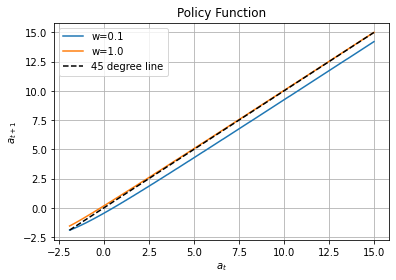

In [135]:
for i in range (2):
    plt.plot(kgrid,g[:,i], '-',label='w='+ str(wgrid[i]))
plt.plot([kmin, kmax], [kmin, kmax], color='black', linestyle='--', label='45 degree line')
plt.grid()
plt.xlabel('$a_t$')
plt.ylabel('$a_{t+1}$')
plt.legend()
plt.title('Policy Function')
plt.show()

## 1(b)

In [112]:
def transQ(g):
    n_k, n_w = g.shape
    n = n_k * n_w
    Q = np.zeros((n, n))
    for j in numba.prange(n):
        i_k = j // n_w
        i_w = j % n_w
        diff = np.abs(g[i_k, i_w] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_w
        j_prime_end = j_prime_start + n_w
        Q[j, j_prime_start:j_prime_end] = P[i_w, :]
    return Q

Q=transQ(g)

Text(0.5, 1.0, 'marginal distribution of k')

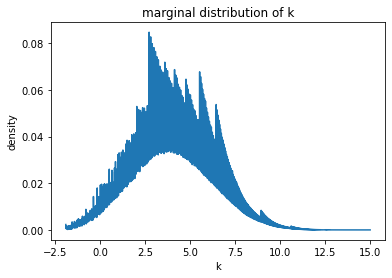

In [127]:
from scipy.sparse.linalg import eigs
k = 1 # 调整为所需的特征值数量
eigenvalues, eigenvectors = eigs(Q.T, k=k, which='LM')  # 'LM'表示计算最大模特征值

index = np.argmin(np.abs(np.abs(eigenvalues)-1.0))
stationary_vector = np.real(eigenvectors[:, index])
stationary_distribution = stationary_vector / np.sum(stationary_vector)

def capital_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_w))
    k_marginal = tmp.sum(axis=1)
    return k_marginal

k_marginal=capital_marginal(stationary_vector)

plt.plot(kgrid,abs(k_marginal))
plt.xlabel("k")
plt.ylabel("density")
plt.title('marginal distribution of k')

## 2

参照hint的思路，我将1里面的函数添加参数“利率”，从而方便接下来的函数编程。

我将1中的代码集成到函数“r_update”中，根据提目的条件更新$r_0$，然后利用上面的迭代函数逼近均衡利率。

最终得到$r_{Equilibrium}=0.0026315789473684184$

In [179]:
rmin=0
rmax=(1/beta)-1
r0=0.05*(rmin+rmax)

In [180]:
def r_update(r):
    # 最优化
    V, g = V_iteration(V0,tol=1e-7,r=r0)
    Q0=transQ(g)
    # 求特征值
    from scipy.sparse.linalg import eigs
    k = 1 # 调整为所需的特征值数量
    eigenvalues, eigenvectors = eigs(Q0.T, k=k, which='LM')  # 'LM'表示计算最大模特征值
    index = np.argmin(np.abs(np.abs(eigenvalues)-1.0))
    stationary_vector = np.real(eigenvectors[:, index])
    stationary_distribution = stationary_vector / np.sum(stationary_vector)
    stationary_distribution =stationary_vector.reshape((n_k, n_w))
    # 算Phi
    Phi = np.sum(stationary_distribution[:,0]*g[:,0])+ np.sum(stationary_distribution[:,1]*g[:,1])
    if Phi >= 0 :
        rmax=r0
    else:
        rmin=r0
    return r0

In [182]:
def r_iteration(r_initial,tol):
    r = r_initial
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        r_new = r_update(r)
        error = np.max(np.abs(r_new - r))
        r = r_new
        count = count + 1
        if count % print_skip == 0:
            print(f"Error at iteration {count} is {error}.")
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return r_new

In [194]:
start_time = timeit.default_timer()
r_eq = r_iteration(r_initial=r0,tol=1e-6)
print("The time difference is :", timeit.default_timer() - start_time)
from IPython.display import Latex
Latex('$r_{Equilibrium}=$'+str(r_eq))

Error at iteration 50 is 0.016787167660273106.
Error at iteration 100 is 0.0012916864689067609.
Error at iteration 150 is 9.938878341708701e-05.
Error at iteration 200 is 7.647467484162007e-06.
Error at iteration 250 is 5.884341991446718e-07.

Converged in 285 iterations.

Converged in 1 iterations.
The time difference is : 2.7688788999998906


<IPython.core.display.Latex object>